In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib2 import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

In [9]:
import numpy as np
from scipy.stats import norm

In [92]:
def relu(x,tol): return (2*tol)*(x.clamp_min(0.) - 0.5*tol)

In [61]:
def plot_dist(data):
    # Fit a normal distribution to the data:
    mu, std = norm.fit(data)

    # Plot the histogram.
    plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)

    plt.show()

In [139]:
for i in range(10):
    d = torch.randn((100))
    print([a-b for a,b in zip(norm.fit(d),(norm.fit(relu(d,0.85))))])

[0.086724944, 0.008578658]
[-0.06603993, -0.030575633]
[-0.00046780566, -0.041481376]
[0.07921444, 0.0056276917]
[0.0048678666, 0.014854252]
[0.028815344, -0.06620729]
[0.01286152, 0.022798538]
[0.09978445, -0.038107395]
[0.031480204, -0.013089895]
[-0.043090124, -0.0018950701]


Best tol values seems to be 0.85 after grid search

In [277]:
def relu(x,tol): return (2*tol)*(x.clamp_min(0.) - 0.5*tol)

In [160]:
data = torch.randn((100))

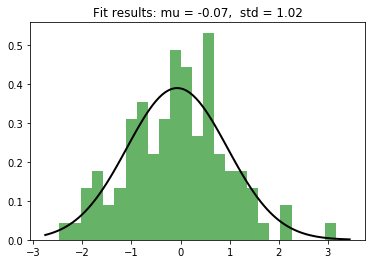

In [274]:
plot_dist(data)

In [278]:
data_relu = relu(data,0.85)

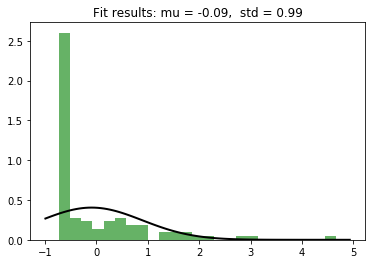

In [279]:
plot_dist(data_relu)

In [166]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [171]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
        
    return map(tensor, (x_train, y_train, x_valid, y_valid))

def normalize(x, m ,s): return (x-m)/s

In [329]:
def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"   
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)
def test_near_zero(a,tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"

In [172]:
x_train, y_train, x_valid, y_valid = get_data()

In [173]:
train_mean, train_std = x_train.mean(), x_train.std()

In [174]:
train_mean, train_std

(tensor(0.1304), tensor(0.3073))

In [175]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [176]:
x_train.mean(), x_train.std()

(tensor(-6.2598e-06), tensor(1.))

In [177]:
n,m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

### Basic architecture

 The kaiming effect

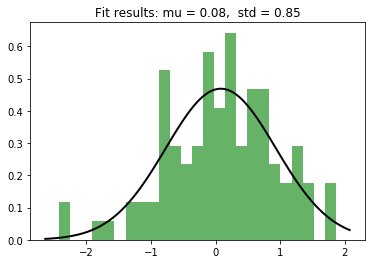

In [221]:
d = torch.randn(100)
plot_dist(d)

Below we are plotting the change to a normal distribution post an affine transformation which in this case is a linear layer operation

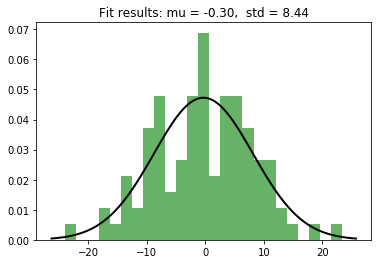

In [261]:
plot_dist(d@torch.randn(100,100)+ torch.zeros(100))

As we see above, the transformation preserves the mean to some extent but the std is scaled, even if we are not sure about statistics, we can empirically find out that we can scale the weights by sqrt(1/m) and control the spread of distribution.
Also note that, since we are scaling distribution hence the skew will add to the y-axis by proportionate amount

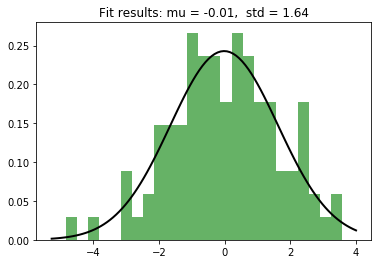

In [252]:
plot_dist(d@(torch.randn(100,100)*math.sqrt(2/100))+ torch.randn(100))

Above graph highlights the effect of kaiming initialization on the affine transformation 

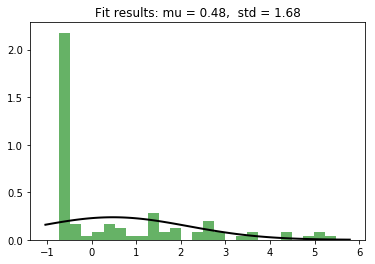

In [268]:
plot_dist(relu(d@(torch.randn(100,100)*math.sqrt(2/100))+ torch.randn(100), 0.85))

We see that post modified relu operation, the distribution is still slightly shifted and std is higher

In [178]:
nh = 50

In [237]:
# kaiming init
w1 = torch.randn(m, nh)*math.sqrt(2./m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)*math.sqrt(2./nh)
b2 = torch.zeros(1)

In [231]:
w1.mean(), w1.std()

(tensor(-0.0003), tensor(0.0505))

In [180]:
def lin(x, w, b): return x@w + b

In [319]:
def sigmoid(x): return 1/(1+torch.exp(-x))

In [284]:
def basic_arc(x_train):
    t1 = lin(x_train, w1, b1)
    t1_relu = relu(t1, 0.85)
    t2 = lin(t1_relu, w2, b2)
    return sigmoid(t2)

In [285]:
%timeit -n 10 _= basic_arc(x_valid)

3.86 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [287]:
basic_arc(x_valid).shape

torch.Size([10000, 1])

In [293]:
def mse(output, target): return (output.squeeze(-1)-target).pow(2).mean()

In [290]:
y_train, y_valid = y_train.float(), y_valid.float()

In [291]:
preds = basic_arc(x_train)

In [294]:
mse(preds, y_train)

tensor(23.9510)

#### Gradients and back propagation

In [295]:
def mse_grad(i, t):
    i.g = 2.*(i.squeeze(-1) - t).unsqueeze(-1)/ i.shape[0]

In [360]:
def relu_grad(i, o, tol):
    i.g = (i>0).float()*o.g*2.*tol #Need to multiply by 2*tol

In [320]:
def sig_grad(i, o):
    i.g = (sigmoid(i)*(1-sigmoid(i))).float()*o.g

In [297]:
def lin_grad(i, o, w, b):
    i.g = o.g@w.t()
    w.g = (i.unsqueeze(-1)*o.g.unsqueeze(1)).sum(0)
    b.g = o.g.sum(0)

In [361]:
def fnb(i,t):
    #forward pass
    tol=0.85
    l1 = lin(i, w1, b1)
    l1_relu = relu(l1, tol)
    l2 = lin(l1_relu, w2, b2)
    l2_sig = sigmoid(l2)
    loss = mse(l2_sig, t)
    
    #backward pass
    mse_grad(l2_sig,t)
    sig_grad(l2, l2_sig)
    lin_grad(l1_relu,l2,w2,b2)
    relu_grad(l1, l1_relu, tol)
    lin_grad(i,l1,w1,b1)

In [362]:
fnb(x_train,y_train)

In [363]:
# Save for testing against later
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig  = x_train.g.clone()

In [364]:
xt2 = x_train.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [365]:
def forward(inp, targ):
    # forward pass:
    l1 = inp @ w12 + b12
    l2 = relu(l1, 0.85)
    l3 = l2 @ w22 + b22
    out = sigmoid(l3)
    # we don't actually need the loss in backward!
    return mse(out, targ)

In [366]:
loss = forward(xt2, y_train)

In [367]:
loss.backward()

In [368]:
test_near(w22.grad, w2g)
test_near(b22.grad, b2g)
test_near(w12.grad, w1g)
test_near(b12.grad, b1g)
test_near(xt2.grad, ig)

Voila, just adding another activation and modifying relu helped me understand and write the backward pass with more confidence and deeper understanding

### Refactoring

In [385]:
class Relu():
    def __call__(self, i):
        self.tol = 0.85
        self.i = i
        self.o = (2.*self.tol)*(i.clamp_min(0.) - 0.5*self.tol)
        return self.o
    
    def backward(self):
        self.i.g = (self.i>0).float()*self.o.g*2.*self.tol

In [414]:
class Sigmoid():
    def __call__(self, i):
        self.i = i
        self.o = 1/(1+torch.exp(-i))
        return self.o
    
    def backward(self):
        self.i.g = self.o*(1 - self.o)*self.o.g
        # Do not use self.__call__(self.i), it is equal to self.o BUT
        # it will clear the maintened gradients

In [415]:
class Lin():
    def __init__(self, w, b): self.w, self.b =w,b
        
    def __call__(self, i):
        self.i = i
        self.o = i@self.w + self.b
        return self.o
    
    def backward(self):
        self.i.g = self.o.g@self.w.t()
        self.w.g = (self.i.unsqueeze(-1)*self.o.g.unsqueeze(1)).sum(0)
        self.b.g = self.o.g.sum(0)

In [416]:
class MSE():
    def __call__(self, i, t):
        self.i = i
        self.t = t
        self.o = (i.squeeze(-1) - t).pow(2).mean()
        return self.o
    
    def backward(self):
        self.i.g = 2.*(self.i.squeeze() - self.t).unsqueeze(-1)/self.t.shape[0]

In [417]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2), Sigmoid()]
        self.loss = MSE()
        
    def __call__(self, x, t):
        for l in self.layers: x = l(x)
        return self.loss(x, t)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [418]:
# Initiliazing with zero grads
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [419]:
%time loss = model(x_train, y_train)

CPU times: user 118 ms, sys: 94.1 ms, total: 212 ms
Wall time: 41.2 ms


In [420]:
%time model.backward()

CPU times: user 5.29 s, sys: 2.79 s, total: 8.08 s
Wall time: 1.42 s


In [421]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, x_train.g)

### Abstracting the self and calls to Module

In [456]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('Not implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [465]:
class Relu(Module):
    # Unfortunately we cannot pass tol with the general call
    def forward(self, inp): tol = 0.85; return (2.*tol)*(inp.clamp_min(0.) - 0.5*tol)
    def bwd(self, out, inp): tol = 0.85; inp.g = (inp>0).float()*out.g*2.*tol

In [466]:
class Sigmoid(Module):
    def forward(self, inp): return 1/(1+torch.exp(-inp))
    def bwd(self, out, inp): inp.g = out*(1-out)*out.g

In [467]:
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
        
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum("bi,bj->ij", inp, out.g)
        self.b.g = out.g.sum(0)

In [468]:
class Mse(Module):
    def forward (self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [469]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2), Sigmoid()]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [470]:
# Initiliazing with zero grads
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [471]:
%time loss = model(x_train, y_train)

CPU times: user 123 ms, sys: 39.4 ms, total: 162 ms
Wall time: 32.5 ms


In [472]:
%time model.backward()

CPU times: user 247 ms, sys: 167 ms, total: 415 ms
Wall time: 85.4 ms


In [473]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, x_train.g)

### Lets use torch.nn now!

In [474]:
from torch import nn

In [477]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        # We are still using our activations
        self.layers = [nn.Linear(n_in,nh), Relu(), nn.Linear(nh,n_out), Sigmoid()]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x.squeeze(), targ)

In [478]:
model = Model(m, nh, 1)

In [479]:
%time loss = model(x_train, y_train)

CPU times: user 105 ms, sys: 31.4 ms, total: 137 ms
Wall time: 31.3 ms


In [480]:
%time loss.backward()

CPU times: user 146 ms, sys: 134 ms, total: 280 ms
Wall time: 75.6 ms


In [481]:
loss

tensor(23.1912, grad_fn=<MeanBackward1>)

__Let's check how the regular Relu performs__

In [488]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        # Now using regular Relu and Sigmoid from torch.nn
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out), nn.Sigmoid()]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x.squeeze(), targ)

In [489]:
model = Model(m, nh, 1)

In [490]:
%time loss = model(x_train, y_train)

CPU times: user 106 ms, sys: 28.7 ms, total: 135 ms
Wall time: 30.7 ms


In [491]:
%time loss.backward()

CPU times: user 110 ms, sys: 38.7 ms, total: 149 ms
Wall time: 34.8 ms


In [492]:
loss

tensor(23.7051, grad_fn=<MeanBackward1>)

__Well it's not exceptionally different but our modefied relu is better and it may compound to significant number given so many layers in a deep networks__